# BBMs for the Optimal Power Flow

In this script, we aim to construct Black-Box Models (BBMs) (i.e., data-driven models) for the Optimal Power Flow (OPF) problem. We use the data stored in the 'data/OPF' folder, containing tables with the OPF IO data.

In general terms, the OPF problem is a non-linear mapping from the input space (i.e., the power injections) to the output space (i.e., the voltage magnitudes and angles): $$ \mathbf{y} = \mathbf{f}(\mathbf{E}, \mathbf{\Pi}), $$ where $\mathbf{E}$ is the vector of power injections and $\mathbf{\Pi}$ is the vector of active and reactive power demands, $\mathbf{\Pi}$ is a vector of the binary status of generators, transmission lines, and transformers (i.e., 1 "on" and 0 "off"), $\mathbf{f}(\cdot)$ is the OPF function, and $\mathbf{y}$ is the vector of optimal voltage magnitudes and angles.

In [144]:
import os

# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tqdm
import datetime
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [100]:
# Choose the dataset to use
inputs_dataset = "input_all_simulations_normalized"
outputs_dataset = "output_all_simulations_3"

# Setting the paths
data_folder = Path("data/OPF/2023-12-06_18-00-46")
input_path = data_folder / f"{inputs_dataset}.npy"
output_path = data_folder / f"{outputs_dataset}.npy"

# Load the CSVs and reset index to 0,1,2,...
input_df = pd.read_csv(data_folder / f"{inputs_dataset}.csv", index_col=0, header=0).reset_index(drop=True)
output_df = pd.read_csv(data_folder / f"{outputs_dataset}.csv", index_col=0, header=0).reset_index(drop=True)

In [101]:
input_df.head()

,Pd,Pd.1,Pd.2,Pd.3,Pd.4,Pd.5,Pd.6,Pd.7,Pd.8,Pd.9,Pd.10,Pd.11,Pd.12,Pd.13,Qd,Qd.1,Qd.2,Qd.3,Qd.4,Qd.5,Qd.6,Qd.7,Qd.8,Qd.9,Qd.10,Qd.11,Qd.12,Qd.13,piGen,piGen.1,piGen.2,piGen.3,piGen.4,piLine,piLine.1,piLine.2,piLine.3,piLine.4,piLine.5,piLine.6,piLine.7,piLine.8,piLine.9,piLine.10,piLine.11,piLine.12,piLine.13,piLine.14,piTrafo,piTrafo.1,piTrafo.2,piTrafo.3,piTrafo.4
0,0.0,0.670798,0.500248,0.464263,0.620128,0.650810,0.0,0.0,0.443465,0.564982,0.557975,0.508669,0.669539,0.636016,0.0,0.553427,0.668262,0.576387,0.655267,0.687400,0.0,0.0,0.464880,0.523002,0.401109,0.593831,0.510095,0.620374,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.643720,0.533173,0.579807,0.611130,0.422920,0.0,0.0,0.432768,0.626437,0.599275,0.426280,0.669478,0.525083,0.0,0.739993,0.466301,0.528463,0.476983,0.590143,0.0,0.0,0.585673,0.563488,0.585877,0.585799,0.501953,0.609652,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.600596,0.514832,0.711147,0.497392,0.548629,0.0,0.0,0.623935,0.669863,0.511458,0.486681,0.605854,0.404861,0.0,0.737159,0.473934,0.444840,0.516689,0.423479,0.0,0.0,0.547895,0.505278,0.570143,0.508154,0.608374,0.430884,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.595724,0.483495,0.577109,0.516462,0.468984,0.0,0.0,0.475017,0.499698,0.415216,0.537111,0.637524,0.605649,0.0,0.575502,0.529381,0.601778,0.453065,0.464239,0.0,0.0,0.618178,0.585627,0.480591,0.728246,0.375658,0.600850,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.501886,0.417167,0.612389,0.571835,0.617818,0.0,0.0,0.506027,0.435867,0.523584,0.434536,0.439215,0.483310,0.0,0.556831,0.598272,0.506621,0.532172,0.523518,0.0,0.0,0.560617,0.528667,0.537266,0.646561,0.540770,0.486759,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [102]:
output_df.head()

,phi,phi.1,Pg,Pg.1,V,V.1,V.2,V.5,V.7
0,0.0,-2.449307,119.042074,22.097926,1.058203,1.043453,1.023394,1.059999,1.040795
1,0.0,-2.518611,122.292513,22.721510,1.059300,1.044210,1.023073,1.059999,1.038228
2,0.0,-2.643894,129.017916,23.992108,1.057842,1.041923,1.020314,1.059999,1.035953
3,0.0,-2.424513,117.756178,21.853135,1.056377,1.041820,1.022026,1.059999,1.036544
4,0.0,-2.251990,109.866263,20.343933,1.054923,1.041433,1.023567,1.059999,1.038026


In [103]:
# Load the data
X_np = np.load(input_path)
Y_np = np.load(output_path)

print(f"Input shape: {X_np.shape}")
print(f"Output shape: {Y_np.shape}")

Input shape: (59620, 53)
Output shape: (59620, 9)


In [104]:
# Locate the rows with NaNs
X_nan_rows = np.where(np.isnan(X_np))[0]
Y_nan_rows = np.where(np.isnan(Y_np))[0]

# Print number of NaNs
print(f"Number of rows with NaNs in X: {len(X_nan_rows)}")
print(f"Number of rows with NaNs in Y: {len(Y_nan_rows)}")

# Delete in X and Y the rows with NaNs
rows_to_delete = np.union1d(X_nan_rows, Y_nan_rows)
print(f"Rows to delete: {rows_to_delete}")

X_np = np.delete(X_np, rows_to_delete, axis=0)
Y_np = np.delete(Y_np, rows_to_delete, axis=0)

# Print new shapes
print(f"Input shape: {X_np.shape}")
print(f"Output shape: {Y_np.shape}")

Number of rows with NaNs in X: 0
Number of rows with NaNs in Y: 45
Rows to delete: [57886 57887 57888 57889 57890 57891 57892 57893 57894 57895 57896 57897
 57898 57899 57900 57901 57902 57903 57904 57905 57906 57907 57908 57909
 57910 57911 57912 57913 57914 57915 57916 57917 57918 57919 57920 57921
 57922 57923 57924 57925 57926 57927 57928 57929 57930]
Input shape: (59575, 53)
Output shape: (59575, 9)


In [105]:
# Convert to torch tensors
X = torch.from_numpy(X_np).float()
Y = torch.from_numpy(Y_np).float()

print(f"Input shape: {X.shape}")
print(f"Output shape: {Y.shape}")

Input shape: torch.Size([59575, 53])
Output shape: torch.Size([59575, 9])


In [145]:
# A metadata dataclass
@dataclass
class DatasetMetadata:
    name : str
    description : str = None
    input_names : list = None
    output_names : list = None
    input_units : list = None
    output_units : list = None

# A custom TensorDataset class to include metadata
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of metadata.
    """
    def __init__(self, *tensors, metadata: DatasetMetadata=None):
        super(CustomTensorDataset, self).__init__(*tensors)
        self.metadata = metadata

In [146]:
# Create a TensorDataset to store the data
dataset = CustomTensorDataset(X, Y)   # dataset[i] = (X[i], Y[i])
dataset[0]

(tensor([0.0000, 0.6708, 0.5002, 0.4643, 0.6201, 0.6508, 0.0000, 0.0000, 0.4435,
         0.5650, 0.5580, 0.5087, 0.6695, 0.6360, 0.0000, 0.5534, 0.6683, 0.5764,
         0.6553, 0.6874, 0.0000, 0.0000, 0.4649, 0.5230, 0.4011, 0.5938, 0.5101,
         0.6204, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]),
 tensor([  0.0000,  -2.4493, 119.0421,  22.0979,   1.0582,   1.0435,   1.0234,
           1.0600,   1.0408]))

# Split the data into training, validation, and test sets

In [107]:
# Split the data into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Split the training set into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 38128
Validation size: 9532
Test size: 11915


In [108]:
# Create a DataLoader to load the data in batches (training)
batch_size = 32
dataloader_training = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [109]:
# Create a DataLoader to load the data in batches (validation)
batch_size = 32
dataloader_validation = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [110]:
# Create a DataLoader to load the data in batches (test)
batch_size = 32
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Tools for training the model

In [140]:
def countdown(t, message=None):
    import time
    while t >=0:
        mins, secs = divmod(t, 60)
        timeformat = '{:02d}:{:02d}'.format(mins, secs)
        if message is not None:
            print(message, end=' ')
        print(timeformat, end='\r')
        time.sleep(1)
        t -= 1

# A general class to store the settings of the model and the training process
class BBMCreator:
    def __init__(self,
                 training_dataloader,
                 validation_dataloader=None,
                 test_dataloader=None,
                 criterion=None,
                 optimizer=None,
                 epochs=1000,
                 print_every=100,
                 device=None,
                 cross_validation=False
                 ):
        self.model = None
        self.optimizer = optimizer
        self.train_dataloader = training_dataloader
        self.validation_dataloader = validation_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion if criterion is not None else nn.MSELoss()
        self.epochs = epochs
        self.print_every = print_every
        self.device = device if device is not None else torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.init_timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

        self.best_val = np.inf

    def instantiate_model(self, model_class, *args, **kwargs):
        self.model = model_class(*args, **kwargs)
        self.model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.best_val = np.inf

    def set_model(self, model):
        self.model = model
        self.model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.best_val = np.inf

    def train_epoch(self, epoch_number):
        # Setup a tqdm progress bar
        bar = tqdm.tqdm(enumerate(self.train_dataloader), total=len(self.train_dataloader),
                        desc=f"Epoch {epoch_number + 1:4}/{self.epochs}",
                        bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

        running_loss = 0.0
        for i, (inputs, benchmark_outputs) in bar:
            # Move the data to the device
            inputs = inputs.to(self.device)
            benchmark_outputs = benchmark_outputs.to(self.device)

            # Zero the parameter gradients
            self.optimizer.zero_grad()

            # Forwards prediction
            predicted_outputs = self.model(inputs)

            # Compute the loss and back-propagate
            loss = self.criterion(predicted_outputs, benchmark_outputs)
            loss.backward()

            # Optimize
            self.optimizer.step()

            # Add the loss to the running loss
            running_loss += loss.item()

            # Update the progress bar every 100 batches
            if (i + 1) % 100 == 0:
                # Get the best val string: if the best val is inf, then print N/A; if it's larger than 0.01, then print 2 decimals; otherwise, print in scientific notation
                best_val_str = "N/A" if self.best_val == np.inf else f"{self.best_val:.2f}" if self.best_val > 0.01 else f"{self.best_val:.2e}"
                bar.set_description(f"Epoch {epoch_number + 1}/{self.epochs} (Loss: {running_loss:.2f}; best val: {best_val_str})")

            # Print inputs, outputs, and loss
            if torch.isnan(loss):
                print(f"Epoch {epoch_number + 1}, Batch {i + 1}")
                print("Inputs: ", inputs)
                print("Outputs: ", predicted_outputs)
                print("Loss: ", loss)

                # Stop the training
                raise Exception("NaN loss")

    def train(self, save_to: Path=None, t_cowntdown=3):
        # Indicate the name of the model that will be trained
        print(f"Training model '{self.model.name}'")

        # Before training, check if the save_to path exists
        if save_to is not None:
            print(f"The folder '{save_to}/' will be created if it does not exist")
            os.makedirs(save_to, exist_ok=True)

        # Print device used for training
        print(f"Training on {self.device}")

        # Initialize countdown
        countdown(t_cowntdown, message="Training starts in: ")

        # Training loop
        for epoch_number in range(self.epochs):
            # Train the model for one epoch
            self.train_epoch(epoch_number)

            # Evaluate the model on the validation set
            if self.validation_dataloader is not None:
                val_loss = self.evaluate_loss_dataloader(self.validation_dataloader)
                if val_loss < self.best_val:
                    self.best_val = val_loss
                    if save_to is not None:
                        self.save_model(save_to, include_timestamp=False, extra_name=f"_{self.init_timestamp}_best")

        # Print a summary of the performance of the model
        print(f"Train loss: {self.evaluate_loss(*next(iter(self.train_dataloader))):.2f}")
        if self.validation_dataloader is not None:
            print(f"Validation loss: {self.evaluate_loss(*next(iter(self.validation_dataloader))):.2f}")
        if self.test_dataloader is not None:
            print(f"Test loss: {self.evaluate_loss(*next(iter(self.test_dataloader))):.2f}")

        # Print a message indicating that the training has finished
        print("Finished!")

        # Save the model
        if save_to is not None:
            self.save_model(save_to)

    def save_model(self, save_to: Path, include_timestamp=True, extra_name=""):
        save_to = Path(save_to)
        model_name = self.model.name
        model_name += extra_name
        if include_timestamp:
            import datetime
            timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            model_name += f"_{timestamp}"
        torch.save(self.model.state_dict(), save_to / Path(f"{model_name}.pt"))

    def evaluate_loss(self, X, Y):
        # Check if data is in the device, and move it if not
        X = X.to(self.device)
        Y = Y.to(self.device)

        # Compute the outputs and the loss
        predicted_Y = self.model(X)
        loss = self.criterion(predicted_Y, Y).item() * len(X)

        # Return the average loss
        return loss / len(X)

    def evaluate_loss_dataloader(self, dataloader):
        # Compute the loss for the entire dataset
        loss = 0.0
        for X, Y in dataloader:
            # Compute the loss for the batch
            loss += self.evaluate_loss(X, Y)

        # Return the average loss
        return loss / len(dataloader)

    def summary(self, save_to: Path=None):
        """
        Creates a table with the summary of the performance of the model
        :return:
        """
        # Check if a results table is already saved
        if save_to is not None:
            save_to = Path(save_to, "model_performances.csv")
            if save_to.exists():
                # If it exists, load it and add the new results
                df = pd.read_csv(save_to, index_col=0)
                df = df.append(self._summary(), ignore_index=True)
            else:
                # If it does not exist, create a new one
                df = self._summary()

            # Save the dataframe
            df.to_csv(save_to)
        else:
            # If no path is provided, just print the summary
            df = self._summary()

        # Return the dataframe
        return df

    def _summary(self):
        """
        Creates a table with the summary of the performance of the model
        :return:
        """
        # Create a dataframe to store the results
        df = pd.DataFrame(columns=["Model", "Train loss", "Validation loss", "Test loss", "Input dataset", "Output dataset", "Input size", "Output size"])

        # Compute the losses
        train_loss = self.evaluate_loss(*next(iter(self.train_dataloader)))
        if self.validation_dataloader is not None:
            val_loss = self.evaluate_loss(*next(iter(self.validation_dataloader)))
        else:
            val_loss = np.nan
        if self.test_dataloader is not None:
            test_loss = self.evaluate_loss(*next(iter(self.test_dataloader)))
        else:
            test_loss = np.nan

        # Dataset names
        input_dataset = input_path.stem

        # Add the results to the dataframe
        df.loc[0] = [self.model.name, train_loss, val_loss, test_loss]

        # Return the dataframe
        return df


In [141]:
# Create the BBMCreator
BBM_creator = BBMCreator(dataloader_training, dataloader_validation)

# BBM 1: a two-layer feedforward neural network

In [142]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 500)
        self.fc2 = nn.Linear(500, output_size)

        self.name = "BBM1_2layers"

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [143]:
# Instantiate the model
BBM_creator.instantiate_model(Net, X_np.shape[1], Y_np.shape[1])

In [45]:
# Train the model
BBM_creator.train(save_to="models")

Training model 'BBM1_2layers'
The folder 'models/' will be created if it does not exist
Training on cuda:0


Epoch 100/100 (Loss: 20286.54; best val: 7.62): 100%|██████████| 1192/1192 [00:03<00:00, 302.42it/s]

Finished training


In [148]:
# Evaluate the best model on the test set
model_path = Path("models/BBM1_2layers_2024-01-30_16-00-11_best.pt")
OPF_BBM_1 = Net(X_np.shape[1], Y_np.shape[1])
OPF_BBM_1.load_state_dict(torch.load(model_path))
OPF_BBM_1.to(device)
OPF_BBM_1.eval()

# Evaluate the model and compute the loss for the entire test set
BBM_creator.set_model(OPF_BBM_1)
test_loss = BBM_creator.evaluate_loss_dataloader(train_dataset)
print(f"Test loss: {test_loss:.2f}")

Test loss: 18.33


## Some predictions and plots

In [113]:
# Load the model from the file, ensure the device is the same
OPF_BBM_1 = Net(X_np.shape[1], Y_np.shape[1])
OPF_BBM_1.load_state_dict(torch.load("models/BBM1_2layers_2024-01-29_16-33-30.pt"))
OPF_BBM_1.to(device)
OPF_BBM_1.eval()

Net(
  (fc1): Linear(in_features=53, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=9, bias=True)
)

In [115]:
OPF_BBM_1_normalized = Net(X_np.shape[1], Y_np.shape[1])
OPF_BBM_1_normalized.load_state_dict(torch.load("models/BBM1_2layers_2024-01-30_16-00-11_best.pt"))
OPF_BBM_1_normalized.to(device)
OPF_BBM_1_normalized.eval()

Net(
  (fc1): Linear(in_features=53, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=9, bias=True)
)

In [79]:
# Let's open single simulation
single_input_normalized = np.load(data_folder / "input_single_example_normalized.npy")
single_input = np.load(data_folder / "input_single_example.npy")
single_output = np.load(data_folder / "output_single_example_3.npy")

# single_input = dataloader_training.dataset[0:100][0].cpu().detach().numpy()
# single_output = dataloader_training.dataset[0:100][1].cpu().detach().numpy()

# Convert to torch tensors
single_input_normalized = torch.from_numpy(single_input_normalized).float().to(device)
single_input = torch.from_numpy(single_input).float().to(device)
single_output = torch.from_numpy(single_output).float().to(device)

# Predict the output over the test set
single_prediction = OPF_BBM_1(single_input)
single_prediction_normalized = OPF_BBM_1_normalized(single_input_normalized)

Output size: 9


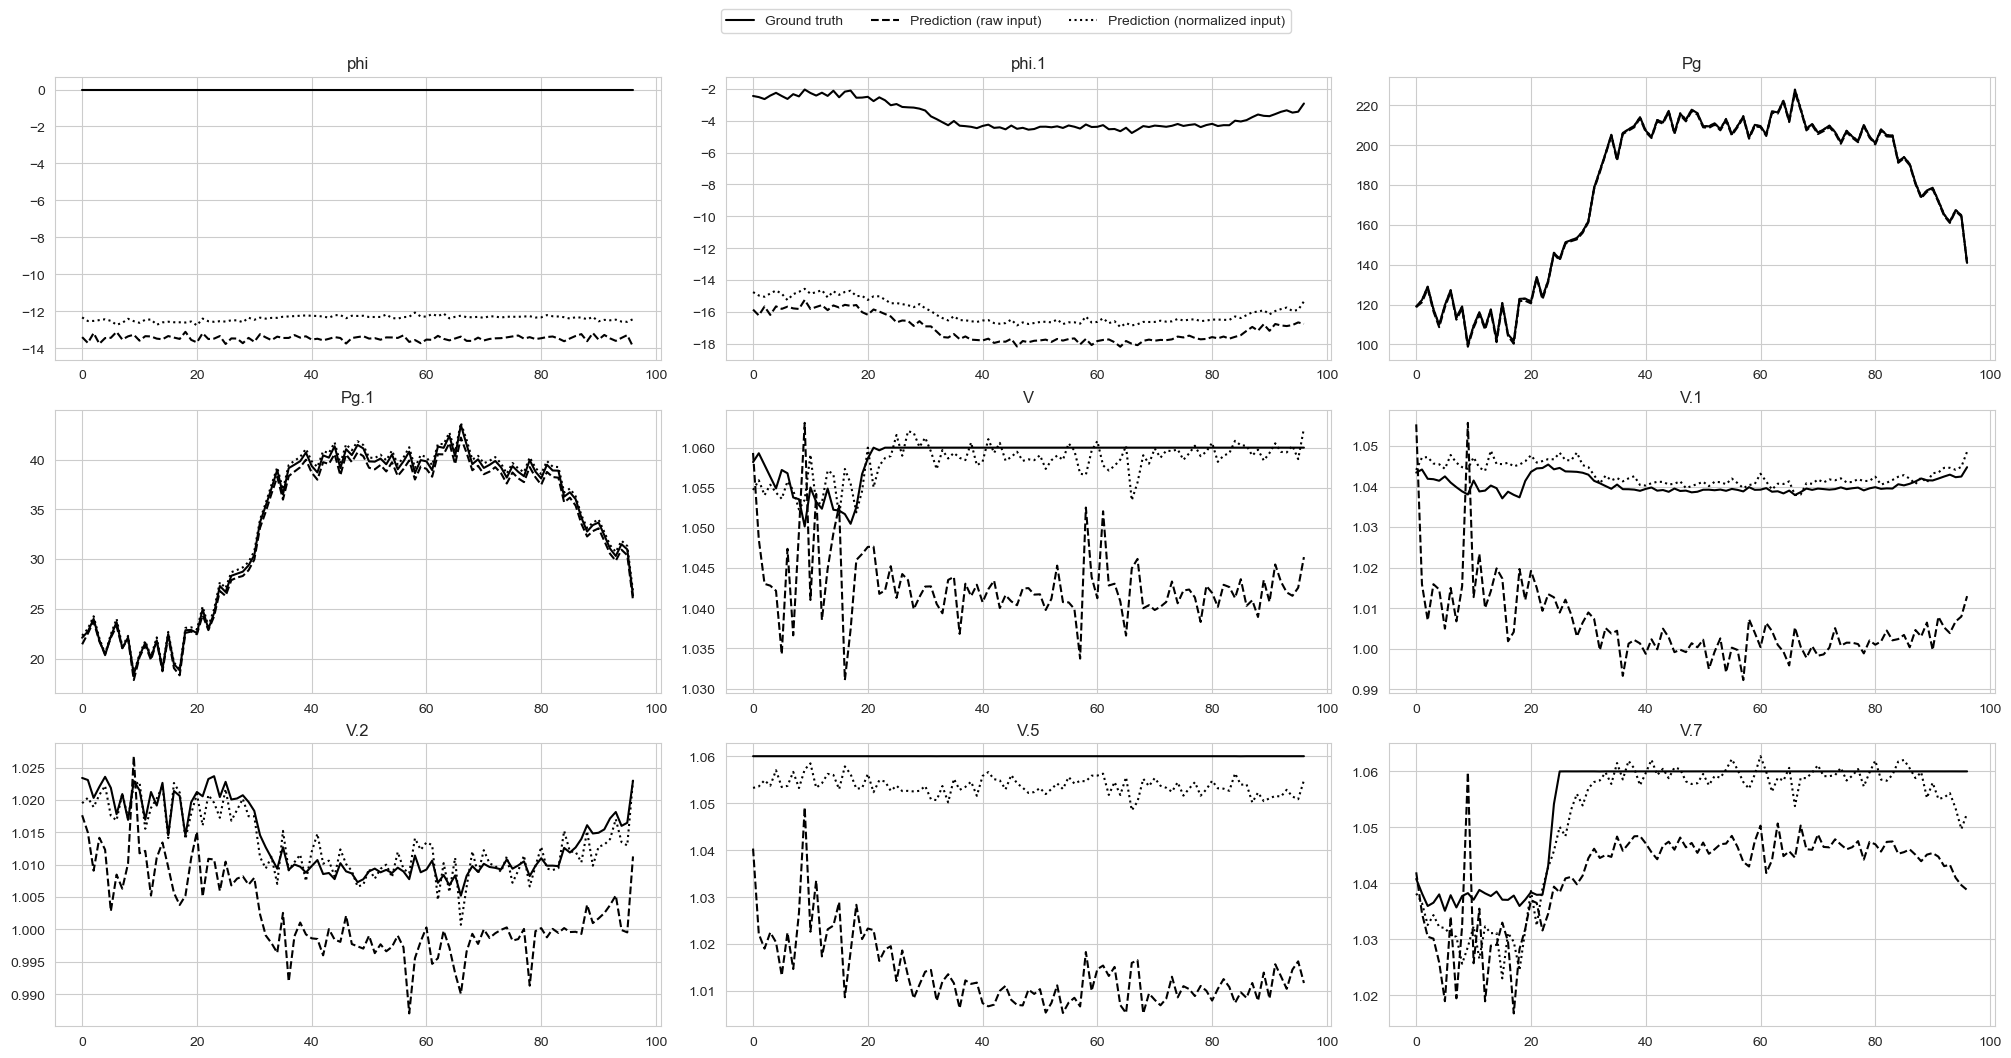

In [87]:
# Obtain the size of the output. THen, create an equal number of subplots and plot predictions versus ground truth in each subplot
output_size = single_output.shape[1]
print(f"Output size: {output_size}")

# Get the names of the outputs from the dataframe
output_names = output_df.columns.values.tolist()

# Calculate a nice number of rows and columns for the subplots
figsize = (20, 10)
rows = int(np.sqrt(output_size))
cols = int(np.ceil(output_size / rows))

# Create the figure
fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)

# Plot the predictions versus the ground truth
for i in range(rows * cols):
    # Delete the axis if there is no data to plot
    if i >= output_size:
        axs[i // cols, i % cols].axis("off")
        continue

    # Calculate the row and column of the subplot
    row = i // cols
    col = i % cols

    # Plot the prediction versus the ground truth
    axs[row, col].plot(single_output[:, i].cpu().detach().numpy(), label="Ground truth", color="black")
    axs[row, col].plot(single_prediction[:, i].cpu().detach().numpy(), label="Prediction (raw input)", color="black", linestyle="--")
    axs[row, col].plot(single_prediction_normalized[:, i].cpu().detach().numpy(), label="Prediction (normalized input)", color="black", linestyle=":")
    axs[row, col].set_title(output_names[i])

# Add a legend at the top
_ = fig.legend(["Ground truth", "Prediction (raw input)", "Prediction (normalized input)"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.05))

# BBM2: A more deep NN
This more complex model considers that the input is mixed (i.e., continuous and discrete variables)

In [72]:
class DeepNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepNN, self).__init__()
        self.name = "BBM2_deep"

        self.input_size = input_size
        self.output_size = output_size

        # Layers
        self.fc1 = nn.Linear(input_size, 500)
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 125)
        self.fc4 = nn.Linear(125, 9)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)


    def forward(self, full_tensor):
        # Process the input
        x = F.relu(self.fc1(full_tensor))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        output = self.fc4(x)
        return output

In [85]:
# Instantiate and train the model
BBM_creator.instantiate_model(DeepNN, X_np.shape[1], Y_np.shape[1])

# Train the model
BBM_creator.train(save_to="models", t_cowntdown=3)

Training model 'BBM2_deep'
The folder 'models/' will be created if it does not exist
Training on cuda:0


Epoch 1000/1000 (Loss: 23827.06; best val: 9.66): 100%|██████████| 1192/1192 [00:04<00:00, 289.67it/s]

Finished training


In [88]:
# Load the model from the file, ensure the device is the same
OPF_BBM_2 = DeepNN(X_np.shape[1], Y_np.shape[1])
OPF_BBM_2.load_state_dict(torch.load("models/BBM2_deep_2024-01-30_18-46-12_best.pt"))
OPF_BBM_2.to(device)
OPF_BBM_2.eval()

DeepNN(
  (fc1): Linear(in_features=53, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=125, bias=True)
  (fc4): Linear(in_features=125, out_features=9, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [92]:
# Compute predictions for the example and add them to the plot
prediction_normalized_2 = OPF_BBM_2(single_input_normalized)

# Plot the predictions versus the ground truth
for i in range(rows * cols):
    # Delete the axis if there is no data to plot
    if i >= output_size:
        axs[i // cols, i % cols].axis("off")
        continue

    # Calculate the row and column of the subplot
    row = i // cols
    col = i % cols

    # Plot the prediction versus the ground truth
    axs[row, col].plot(prediction_normalized_2[:, i].cpu().detach().numpy(), label="Prediction (deep NN)", color="red", linestyle="-.")

# Include in the legend the new prediction; delete the old legend and create a new one
_ = fig.legend(["Ground truth", "Prediction (raw input)", "Prediction (normalized input)", "Prediction (deep NN)"], loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.05))

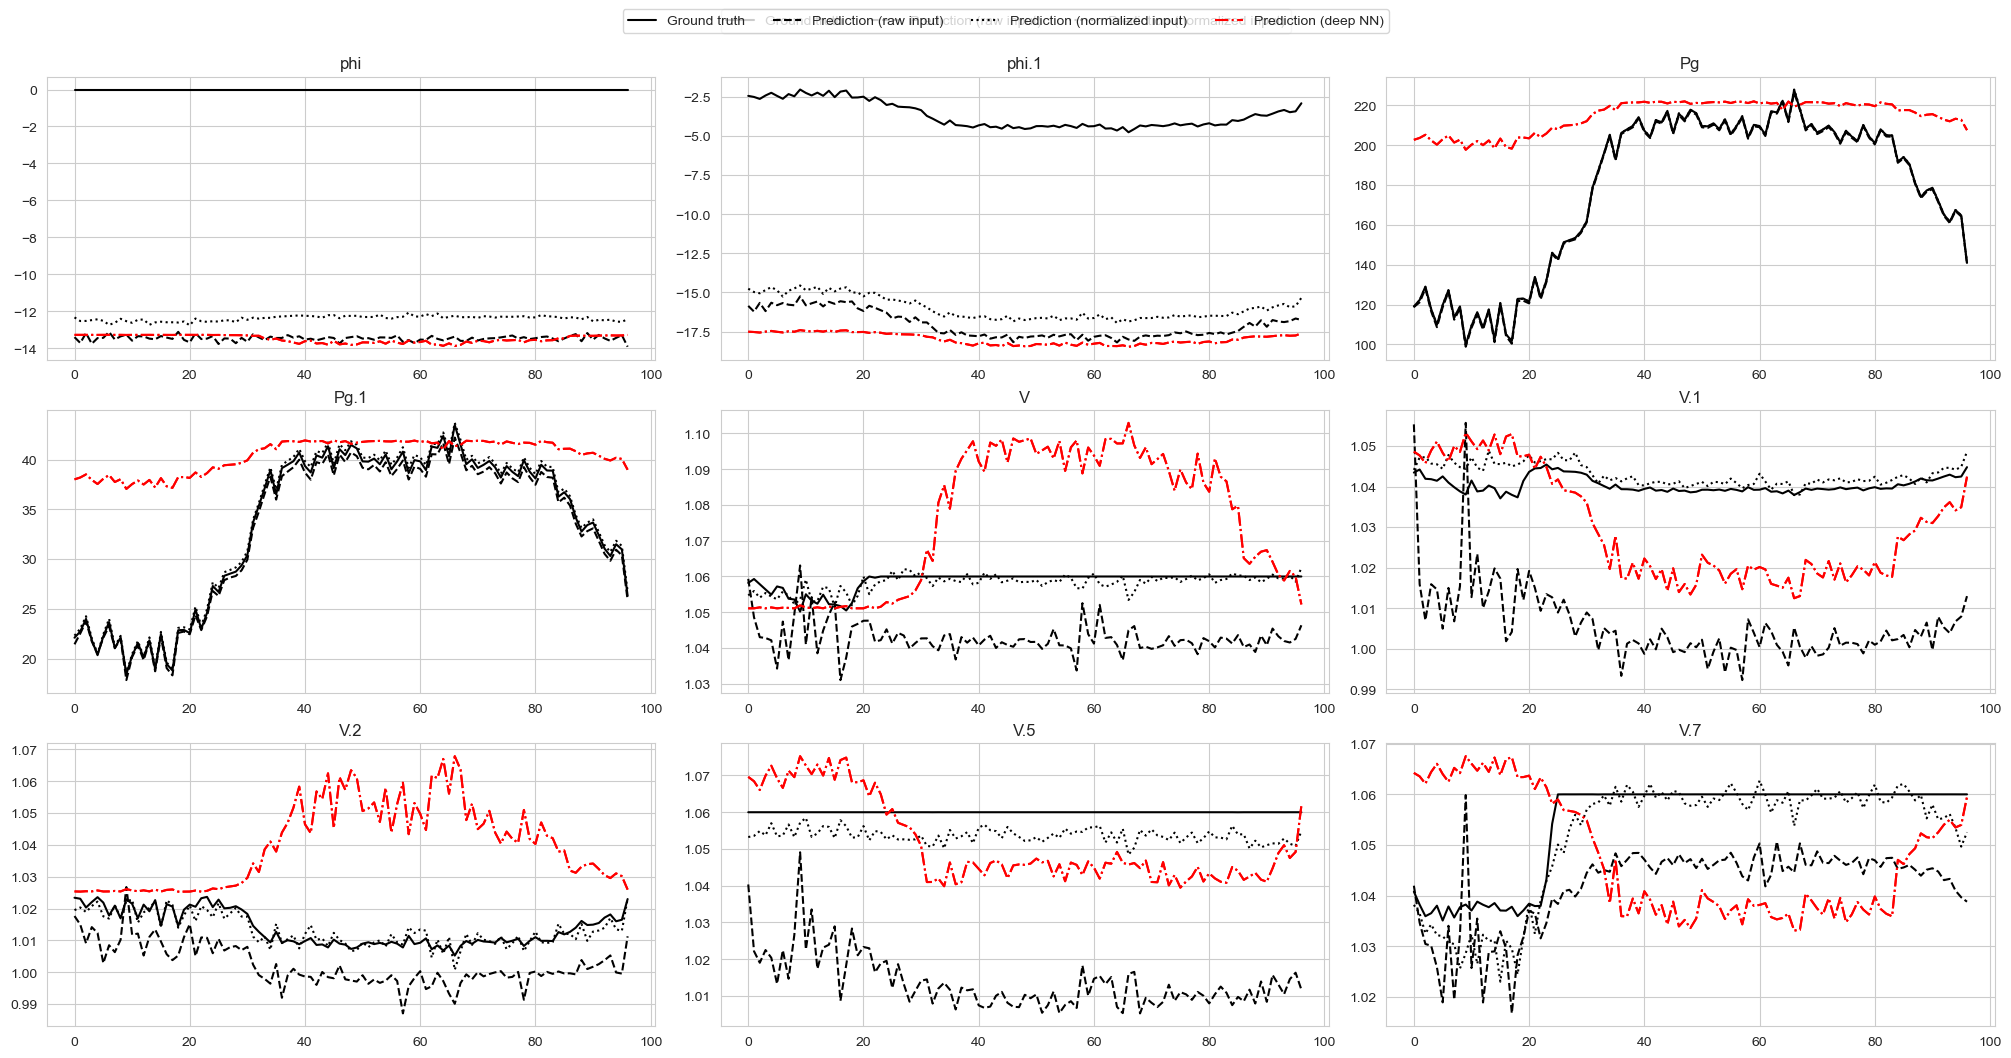

In [93]:
fig

In [65]:
class MixedInputModel(nn.Module):
    def __init__(self, continuous_size, discrete_size, output_size):
        super(MixedInputModel, self).__init__()

        self.name = "BBM2_mixed_input"

        self.continuous_size = continuous_size
        self.discrete_size = discrete_size
        self.output_size = output_size

        # Layers for continuous data
        self.fc1_cont = nn.Linear(continuous_size, 128)
        self.fc2_cont = nn.Linear(128, 64)

        # Layers for discrete data
        self.fc1_disc = nn.Linear(discrete_size, 128)
        self.fc2_disc = nn.Linear(128, 64)

        # Combined layers
        self.fc1_combined = nn.Linear(128, 64)
        self.fc2_combined = nn.Linear(64, output_size)

    def forward(self, full_tensor):
        # Split the tensor into continuous and discrete data
        lambda_tensor = full_tensor[:, :self.continuous_size]
        pi_tensor = full_tensor[:, self.continuous_size:]

        # Process continuous data
        cont = F.relu(self.fc1_cont(lambda_tensor))
        cont = F.relu(self.fc2_cont(cont))

        # Process discrete data
        disc = F.relu(self.fc1_disc(pi_tensor))
        disc = F.relu(self.fc2_disc(disc))

        # Combine the two
        combined = torch.cat((cont, disc), dim=1)
        combined = F.relu(self.fc1_combined(combined))
        output = self.fc2_combined(combined)
        return output

In [64]:
# Instantiate and train the model
continuous_size = 28
discrete_size = 25
output_size = 9
BBM_creator.instantiate_model(MixedInputModel, continuous_size, discrete_size, output_size)

# Train the model
BBM_creator.train()

AttributeError: 'MixedInputModel' object has no attribute 'name'